<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%83%9D%EC%8B%9C%EB%B9%84%20%EC%9D%B8%EC%83%81%20%EC%9D%B4%ED%9B%84%20%EA%B7%80%EA%B0%80%20%ED%8C%A8%ED%84%B4%20%EB%B3%80%ED%99%94%20%EB%B6%84%EC%84%9D/%EC%A7%80%ED%95%98%EC%B2%A0%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%A0%84%EC%B2%B4%EC%8B%9C%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumBarunGothic'
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

!pip install pyspark
!pip install tslearn

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f1620d4a3466eee614ce45a0e51ad038e6b2f76a125aeccd5cdd867b379a7b7f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 5.8 MB/s eta 0:00:00


# Preprocessing

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/BADA/바다톤/data/바다톤_지하철_일별_지역구별_하차승객수.csv', index_col=0)
sub

,area,하차총승객수
사용일자,,
20221201,강남구,690730
20221201,강서구,235186
20221201,관악구,173855
20221201,노원구,205567
20221201,송파구,329212
...,...,...
20230331,강남구,757252
20230331,강서구,258319
20230331,관악구,192214


In [ ]:
sub = sub.reset_index()
sub['사용일자'] = sub['사용일자'].astype(str)
sub['사용일자'] = pd.to_datetime(sub['사용일자'], format='%Y-%m-%d'); sub

,사용일자,area,하차총승객수
0,2022-12-01,강남구,690730
1,2022-12-01,강서구,235186
2,2022-12-01,관악구,173855
3,2022-12-01,노원구,205567
4,2022-12-01,송파구,329212
...,...,...,...
600,2023-03-31,강남구,757252
601,2023-03-31,강서구,258319
602,2023-03-31,관악구,192214
603,2023-03-31,노원구,226710


In [ ]:
sub.rename(columns = {'사용일자': 'date', '하차총승객수': 'count'}, inplace=True); sub

,date,area,count
0,2022-12-01,강남구,690730
1,2022-12-01,강서구,235186
2,2022-12-01,관악구,173855
3,2022-12-01,노원구,205567
4,2022-12-01,송파구,329212
...,...,...,...
600,2023-03-31,강남구,757252
601,2023-03-31,강서구,258319
602,2023-03-31,관악구,192214
603,2023-03-31,노원구,226710


In [ ]:
sub = pd.DataFrame(sub.groupby(['area','date']).sum()['count']); sub

count
area date              
강남구  2022-12-01  690730
     2022-12-02  724335
     2022-12-03  442466
     2022-12-04  270965
     2022-12-05  678126
...                 ...
송파구  2023-03-27  352065
     2023-03-28  362901
     2023-03-29  371030
     2023-03-30  378187
     2023-03-31  405597

[605 rows x 1 columns]

In [ ]:
sub = sub.reset_index(level=0); sub

,area,count
date,,
2022-12-01,강남구,690730
2022-12-02,강남구,724335
2022-12-03,강남구,442466
2022-12-04,강남구,270965
2022-12-05,강남구,678126
...,...,...
2023-03-27,송파구,352065
2023-03-28,송파구,362901
2023-03-29,송파구,371030


In [ ]:
sub_강남 = sub[sub['area']=='강남구']
sub_강서 = sub[sub['area']=='강서구']
sub_관악 = sub[sub['area']=='관악구']
sub_노원 = sub[sub['area']=='노원구']
sub_송파 = sub[sub['area']=='송파구']

#데이터의 분포 살펴보기

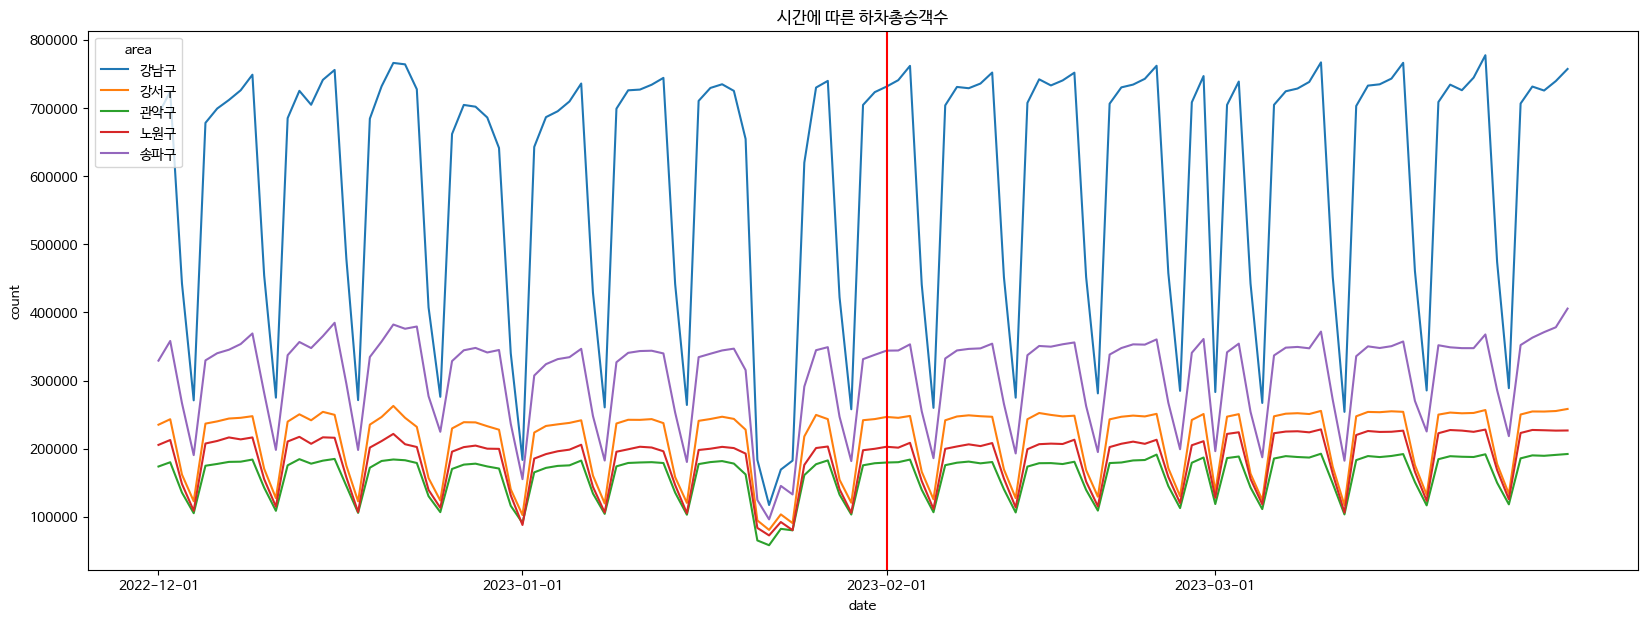

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.lineplot(x=sub.index, y=sub['count'], hue=sub['area'])
plt.title('시간에 따른 하차총승객수')
ax.set_xticks([datetime(2022,12,1),datetime(2023,1,1),datetime(2023,2,1),datetime(2023,3,1)], ['2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01'])
plt.axvline(x=datetime(2023,2,1), ymin=0, ymax=800000, color='red', linestyle='solid')
plt.show()

# stationarity 검정

In [ ]:
def adfuller_test(df):
        result = adfuller(df)

        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

        for label, value in zip(labels, result):
            print(label + ' : ' + str(value) )

        if result[1] <= 0.05:
            print('정상성', '\n')
        else:
            print('비정상성', '\n')

In [ ]:
adfuller_test(sub_강남['count'])
adfuller_test(sub_강서['count'])
adfuller_test(sub_관악['count'])
adfuller_test(sub_노원['count'])
adfuller_test(sub_송파['count'])

ADF Test Statistic : -3.828207609223151
p-value : 0.002631546588051526
#Lags Used : 8
Number of Observations Used : 112
정상성 

ADF Test Statistic : -3.0292231408578556
p-value : 0.03225399126415302
#Lags Used : 7
Number of Observations Used : 113
정상성 

ADF Test Statistic : -2.378431467710417
p-value : 0.14791672655572302
#Lags Used : 10
Number of Observations Used : 110
비정상성 

ADF Test Statistic : -0.9667968582261875
p-value : 0.7651809848592697
#Lags Used : 13
Number of Observations Used : 107
비정상성 

ADF Test Statistic : -3.295590187911021
p-value : 0.015076747641390024
#Lags Used : 8
Number of Observations Used : 112
정상성 



관악구, 노원구 => 비정상성

# 전체적인 주별 추세 확인(이동평균법)

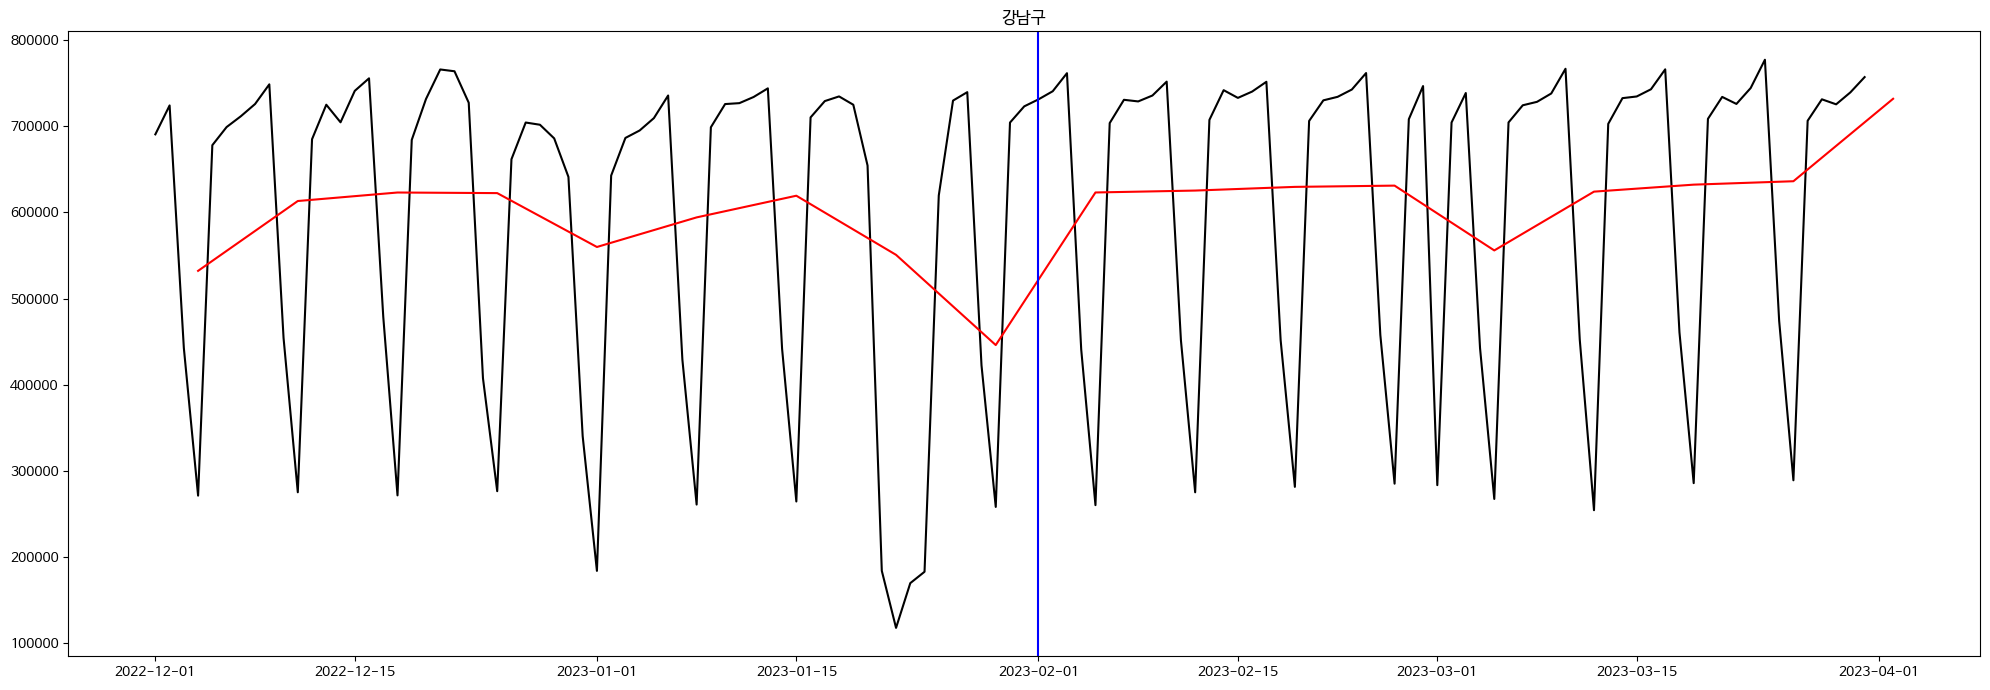

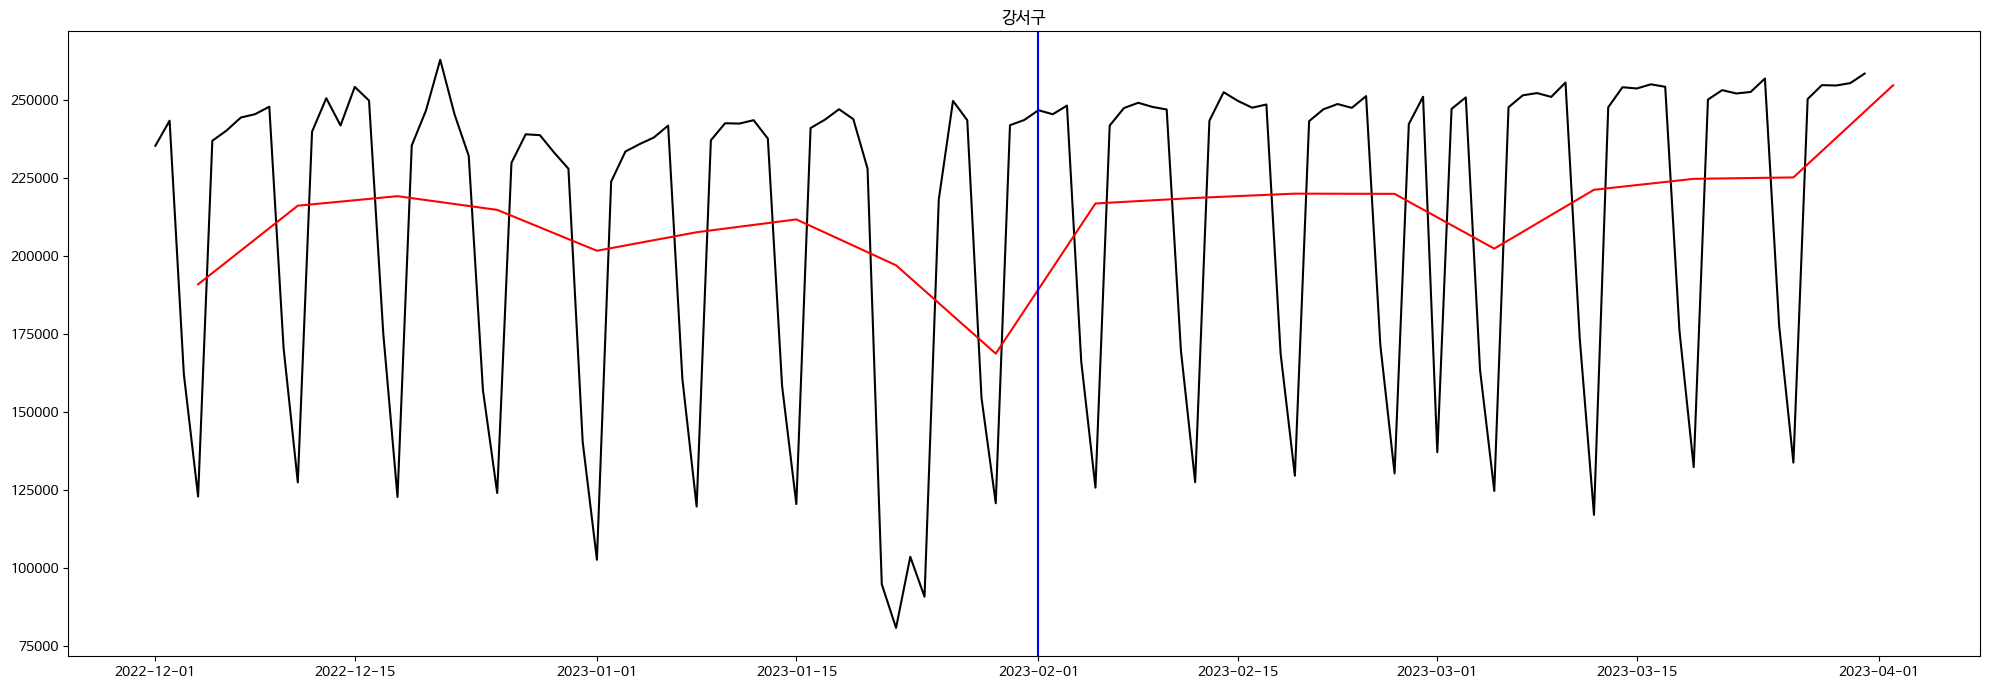

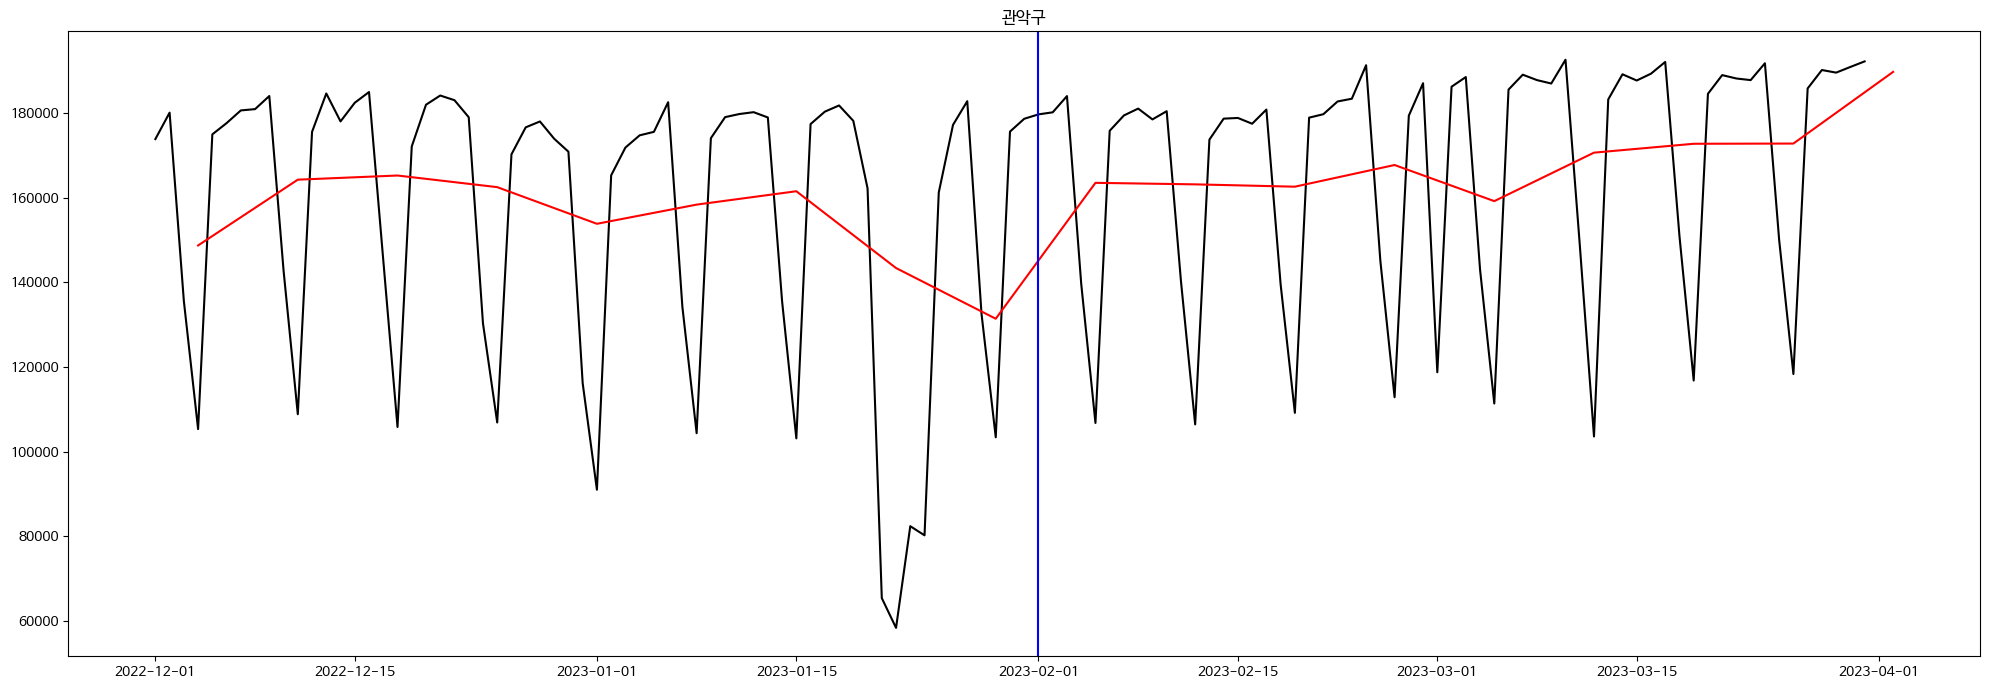

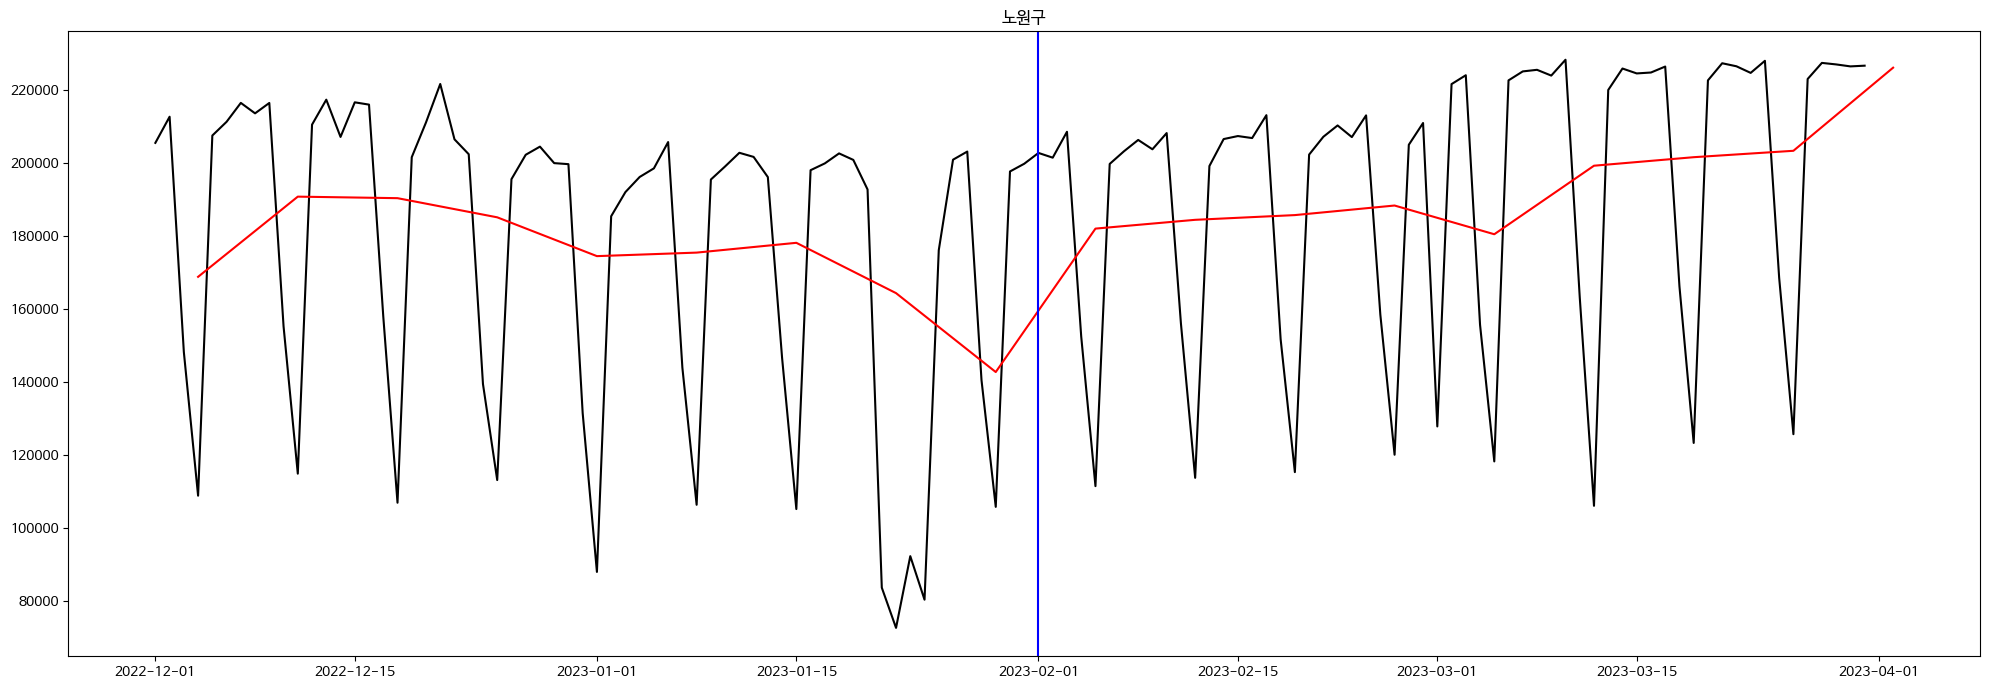

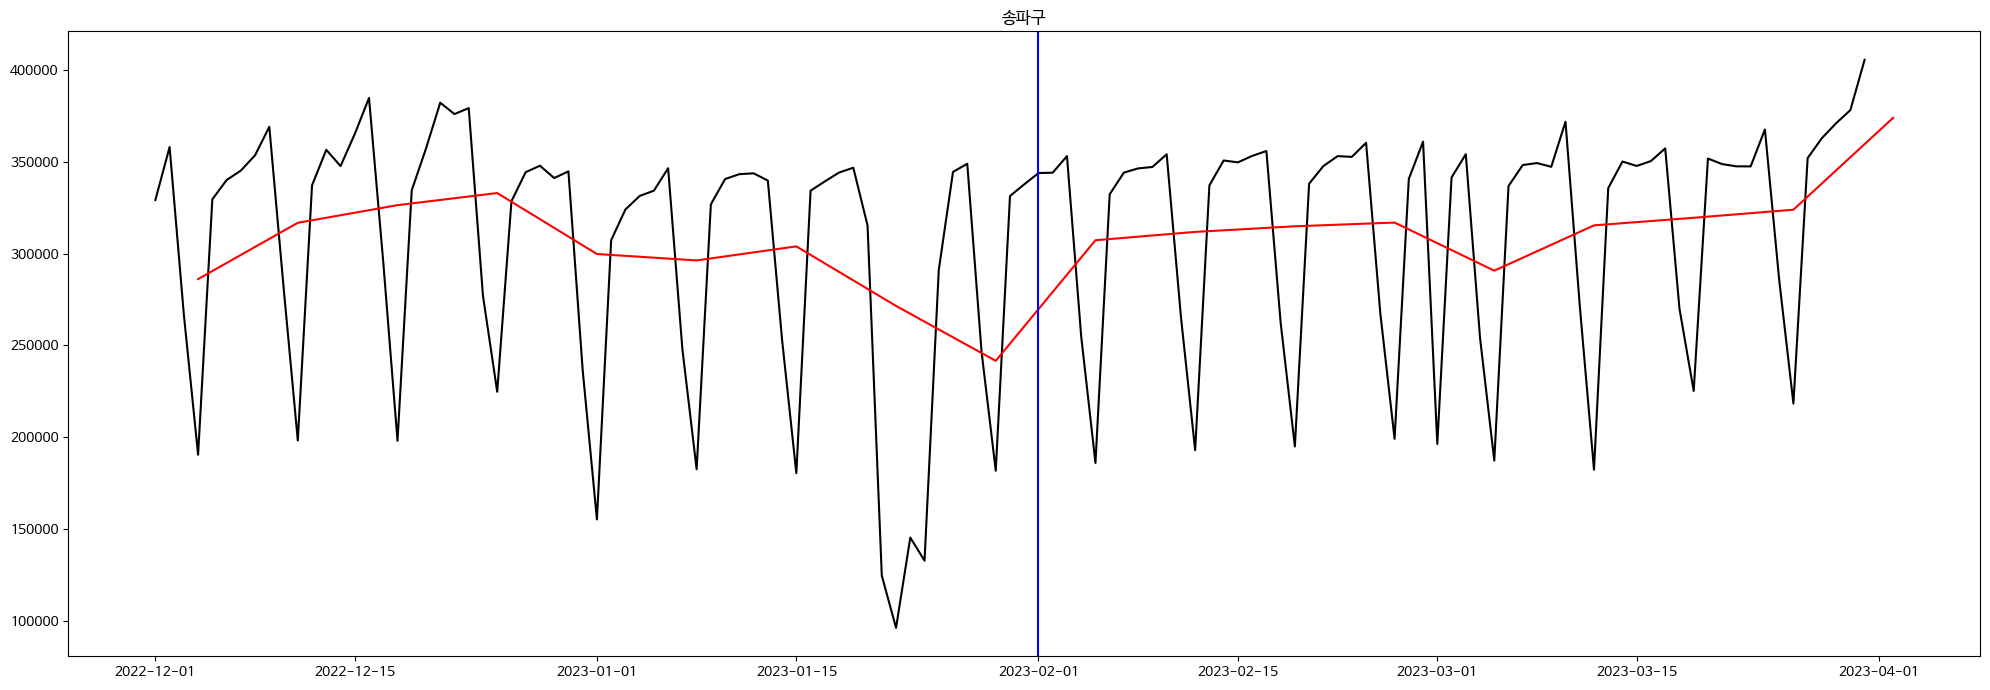

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.figure(figsize=(20,7))
    plt.title(df['area'][0])
    plt.plot(df['count'], 'k')
    plt.plot(df['count'].resample('W').mean(), 'r')  #resamples the time series data to weekly frequency and computes the mean for each week.
    plt.axvline(x=datetime(2023,2,1), ymin=0, ymax=800000, color='blue', linestyle='solid')
    plt.tight_layout()
    plt.show()

#전체적인 월별 추세 확인

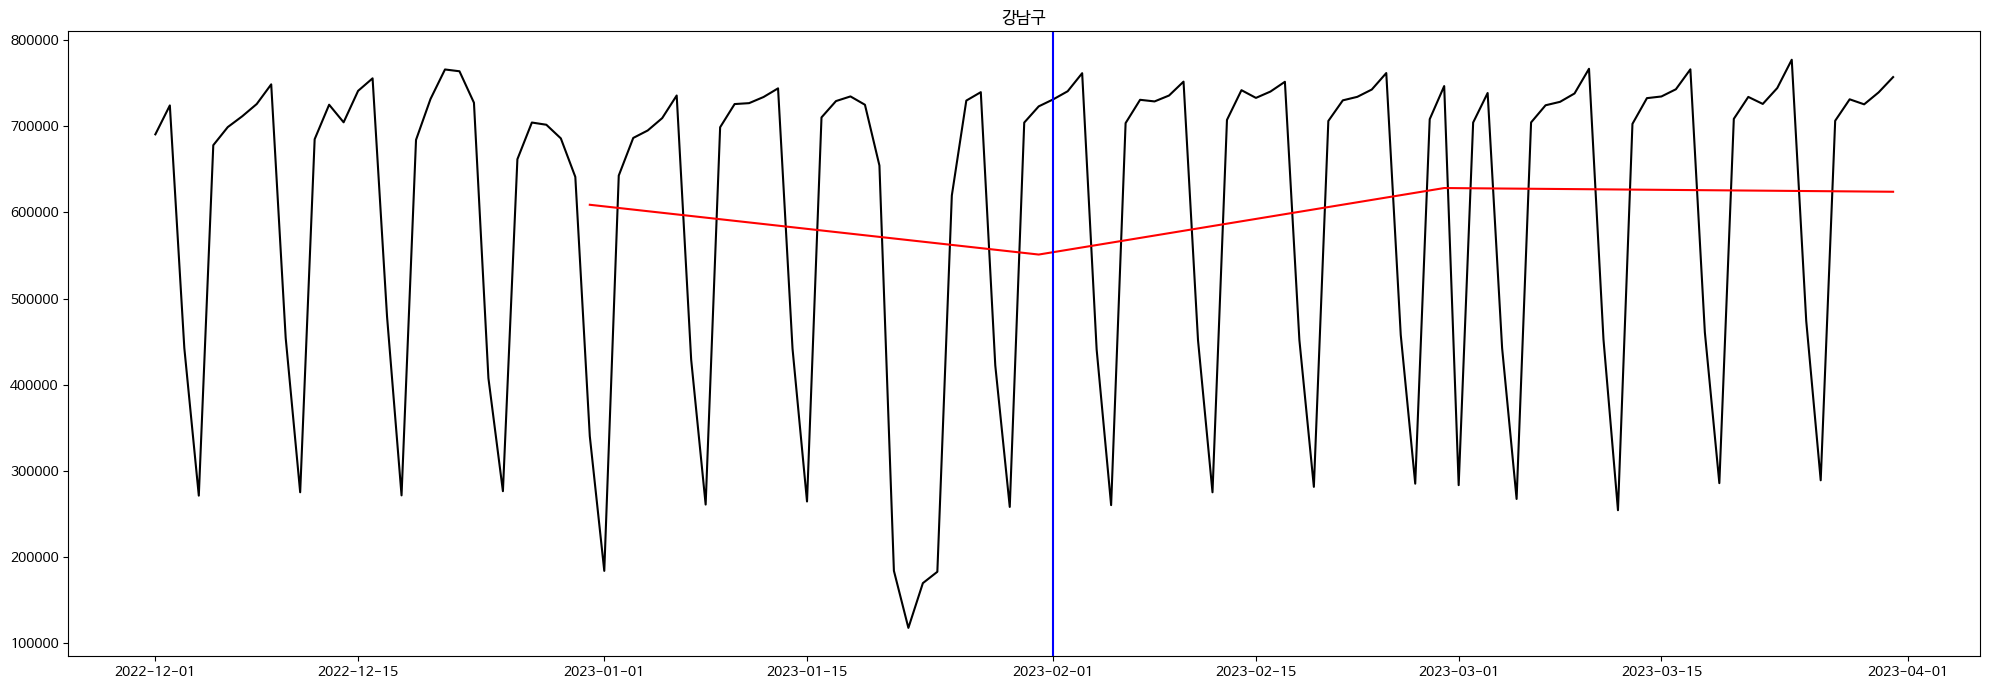

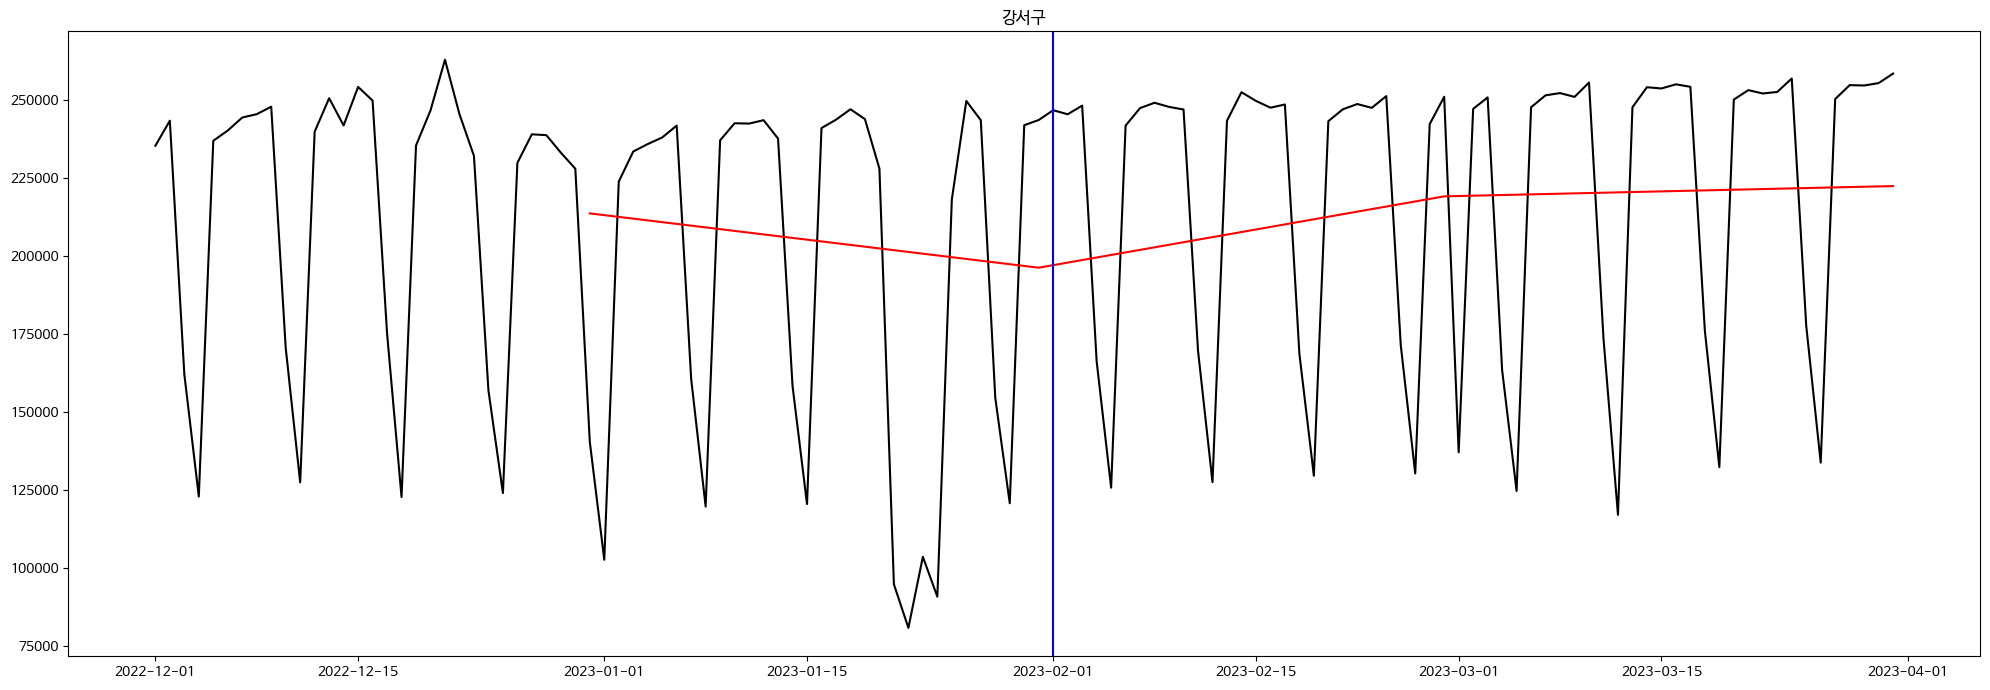

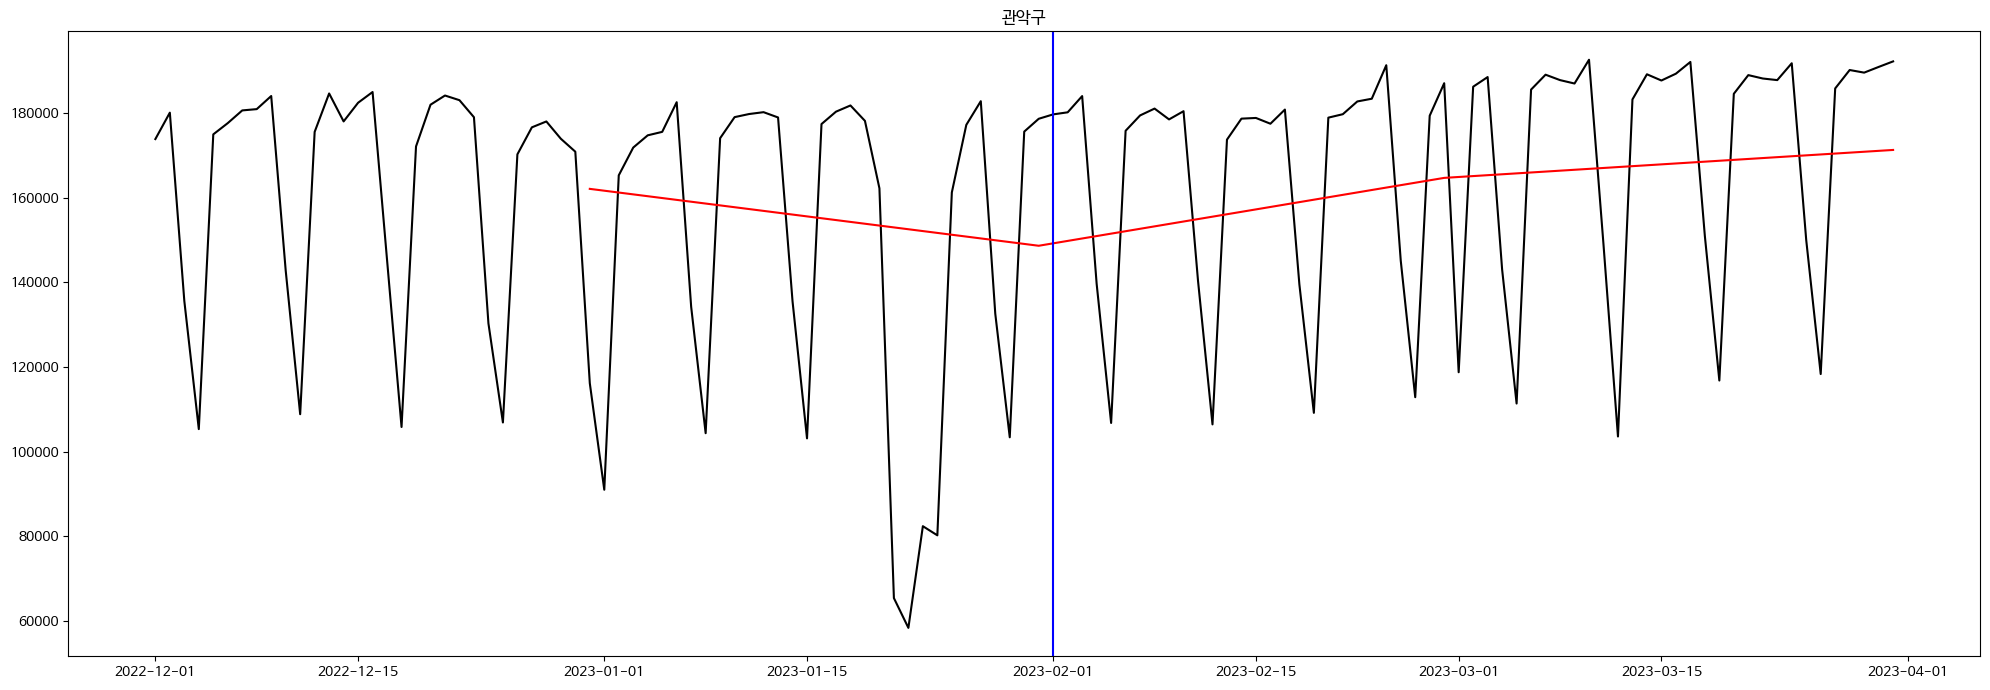

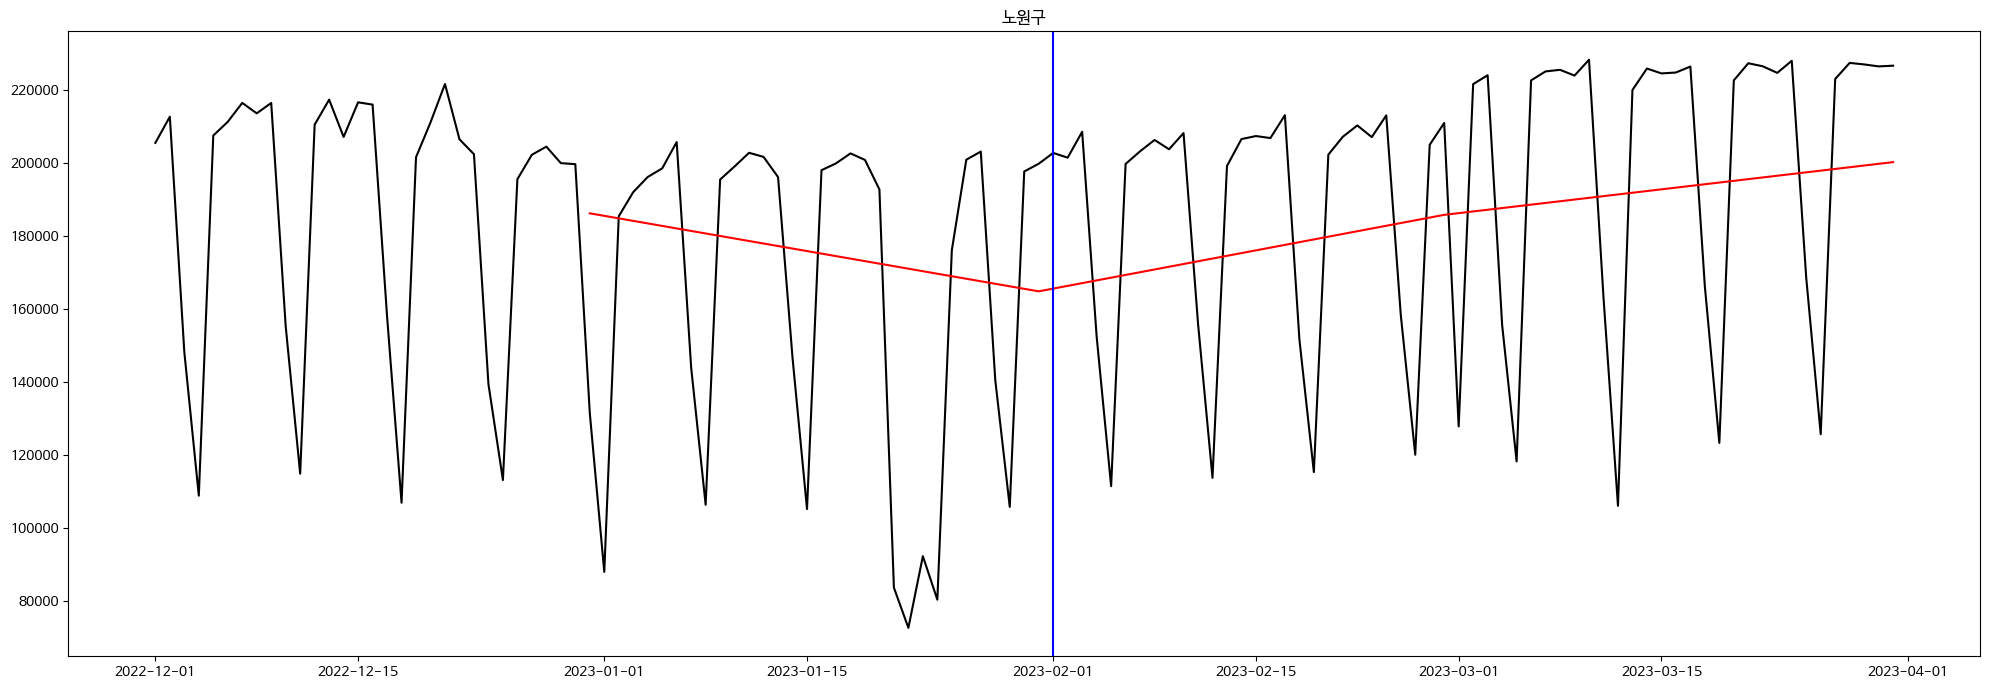

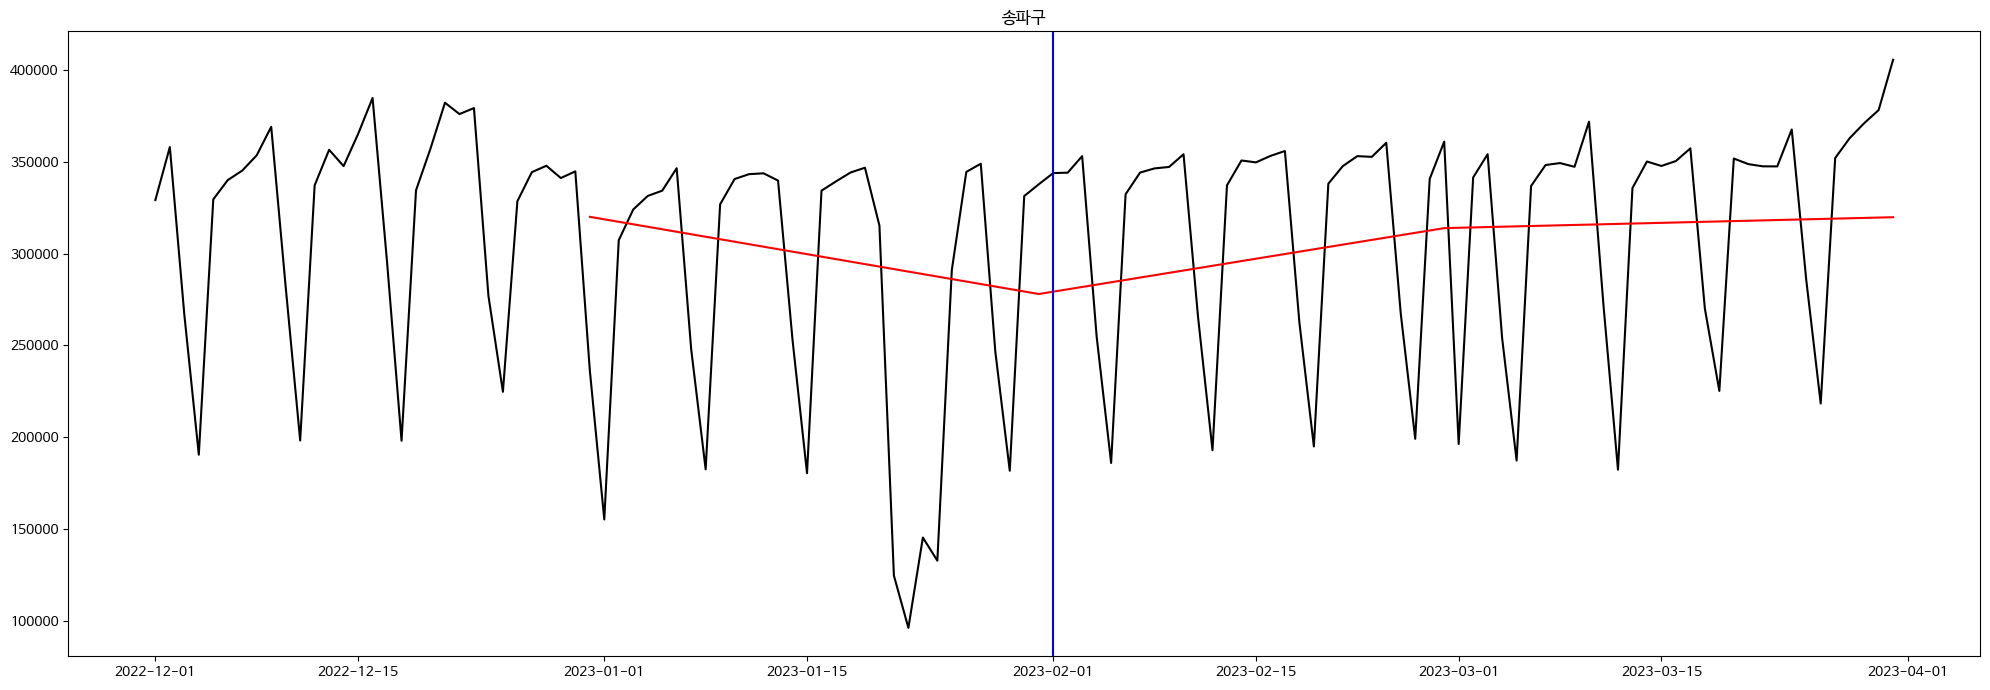

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.figure(figsize=(20,7))
    plt.title(df['area'][0])
    plt.plot(df['count'], 'k')
    plt.plot(df['count'].resample('M').mean(), 'r')  #resamples the time series data to monthly frequency and computes the mean for each month.
    plt.axvline(x=datetime(2023,2,1), ymin=0, ymax=800000, color='blue', linestyle='solid')
    plt.tight_layout()
    plt.show()

# seasonal decompose

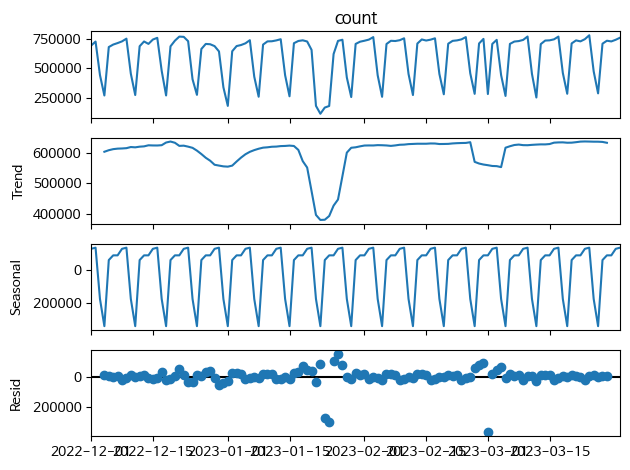

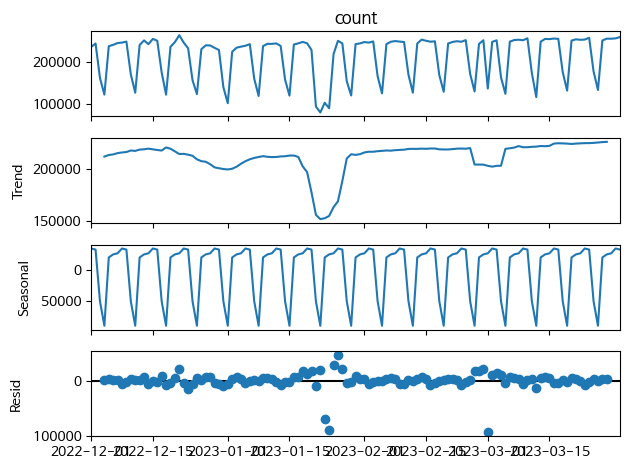

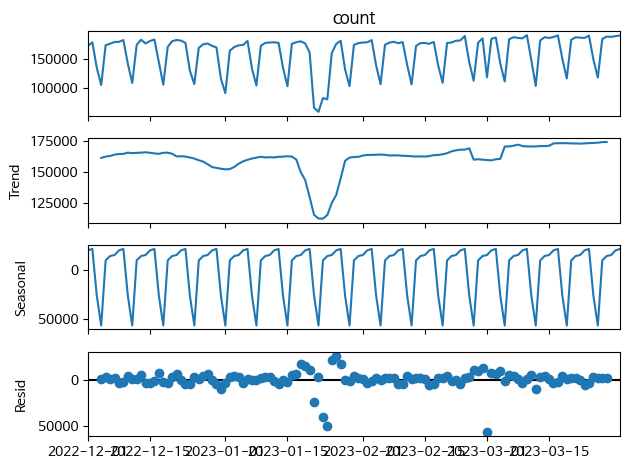

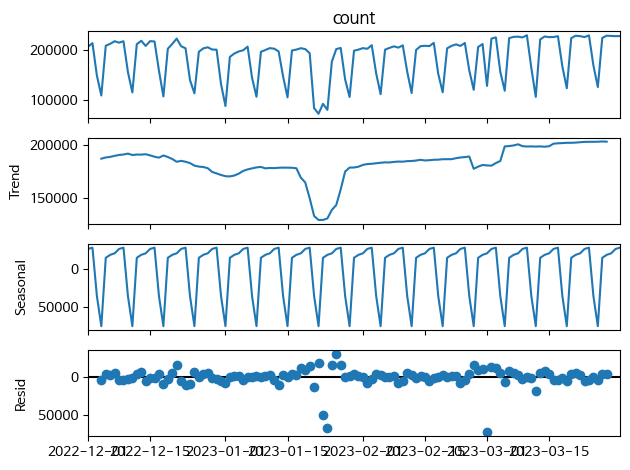

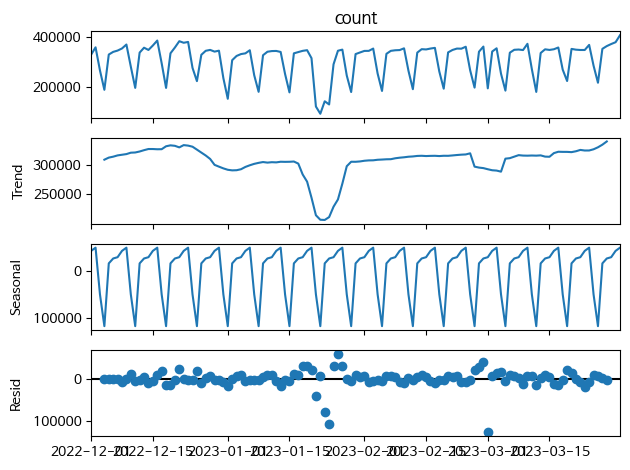

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    series = df['count']
    result = seasonal_decompose(series, model='additive')
    result.plot()

#차분

In [ ]:
def difference(df):
    sub_diff = df['count'].diff()
    sub_diff = sub_diff.dropna()
    return adfuller_test(sub_diff)

In [ ]:
difference(sub_관악)

ADF Test Statistic : -3.5302821159641025
p-value : 0.007242603512204231
#Lags Used : 13
Number of Observations Used : 106
정상성 



In [ ]:
difference(sub_노원)

ADF Test Statistic : -3.7010569363211983
p-value : 0.0040983119219826225
#Lags Used : 13
Number of Observations Used : 106
정상성 



관악, 노원에 대해서는 차분을 1회 진행한다.

나머지는 차분 안함.

#acf, pacf

In [ ]:
def acf_pacf(df):
    ax1 = sm.graphics.tsa.plot_acf(df['count'])
    plt.xlabel(df['area'][0])
    plt.show()

    ax2 = sm.graphics.tsa.plot_pacf(df['count'])
    plt.xlabel(df['area'][0])
    plt.show()

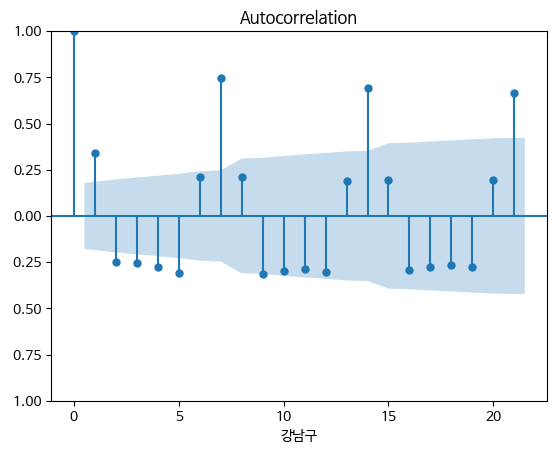

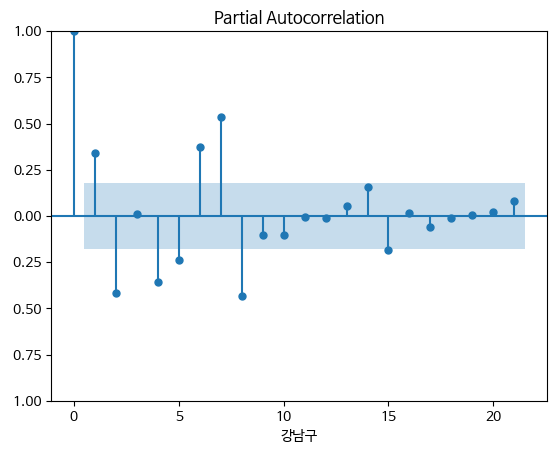

In [ ]:
acf_pacf(sub_강남)

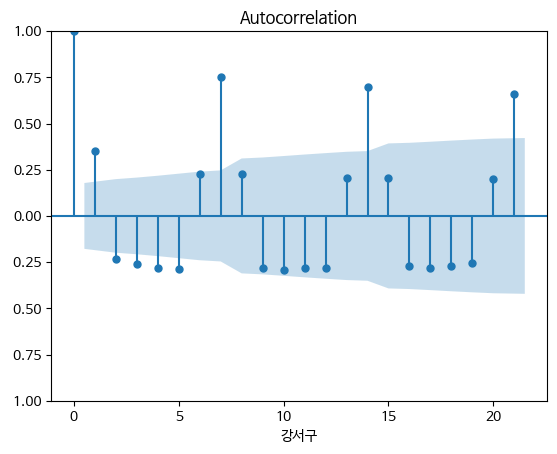

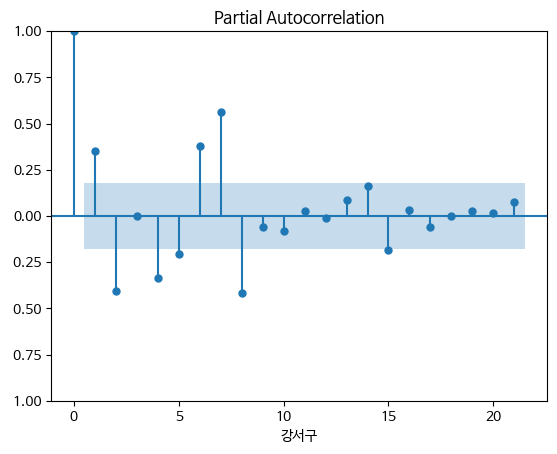

In [ ]:
acf_pacf(sub_강서)

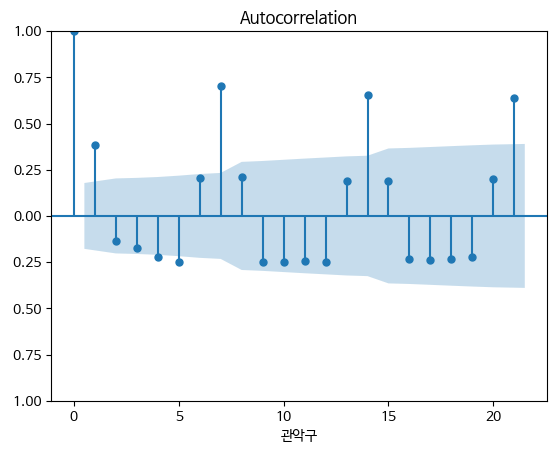

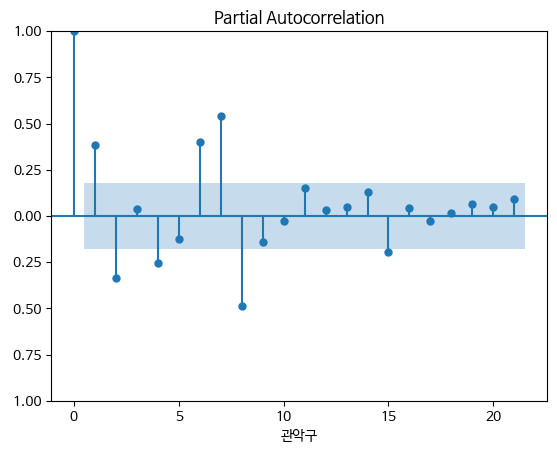

In [ ]:
acf_pacf(sub_관악)

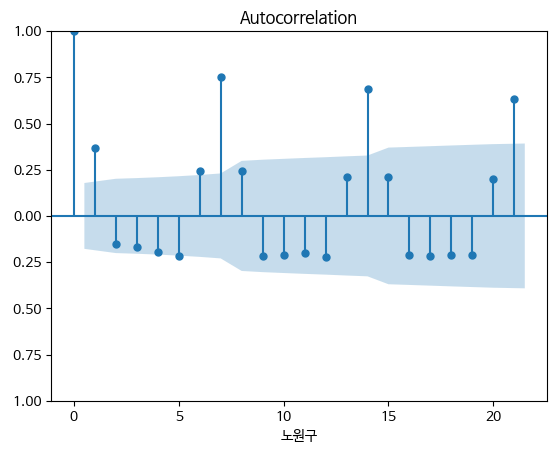

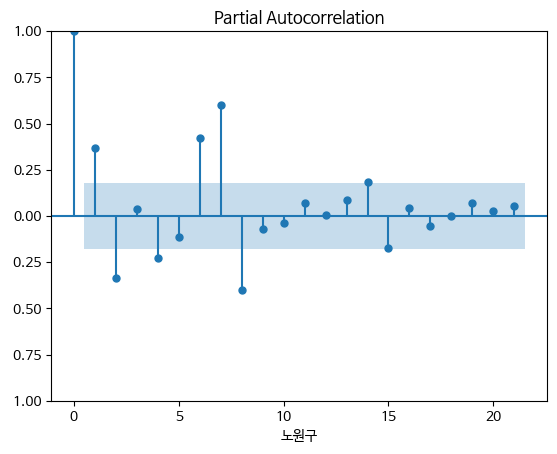

In [ ]:
acf_pacf(sub_노원)

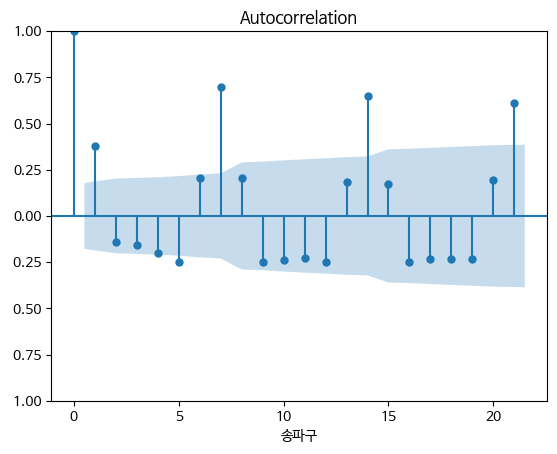

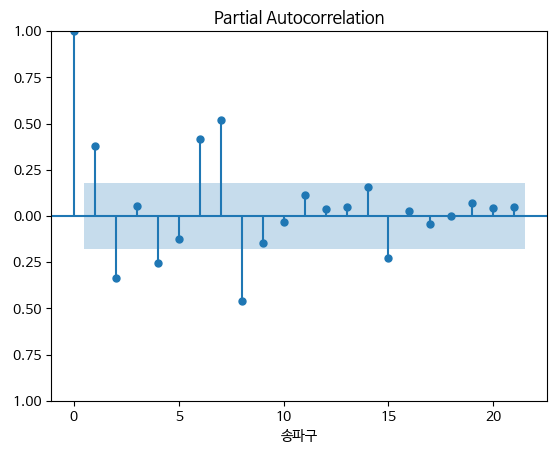

In [ ]:
acf_pacf(sub_송파)

# SARIMA

In [ ]:
def SARIMA(df):

    df.index = pd.DatetimeIndex(df.index.values, freq='D')

    i=0
    p = d = q = P = D = Q = list(range(0, 2))
    S = [7]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, S))
    best_pdq = None
    best_seasonal_pdq = None
    best_aic = float('inf')
    best_model = None
    best_result = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(df['count'], order=param, seasonal_order=seasonal_param)
                result = model.fit()
                aic = result.aic
                i += 1
                if (aic < best_aic) & (aic > 1000):
                    best_aic = aic
                    best_pdq = param
                    best_seasonal_pdq = seasonal_param
                    best_model = model
                    best_result = result
                if i % 30 == 0:
                    print(i)
            except:
                continue

    print('Best SARIMA{}x{} model >> AIC: {}'.format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_result.summary())

    best_result.plot_diagnostics(figsize=(15,12))
    plt.show()

    #잔차에 담기
    df['resid'] = best_result.resid

30
60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2927.725149040356
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1460.863
Date:                             Tue, 07 Nov 2023   AIC                           2927.725
Time:                                     05:13:49   BIC                           2935.907
Sample:                                 12-01-2022   HQIC                          2931.045
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1881      0.099  

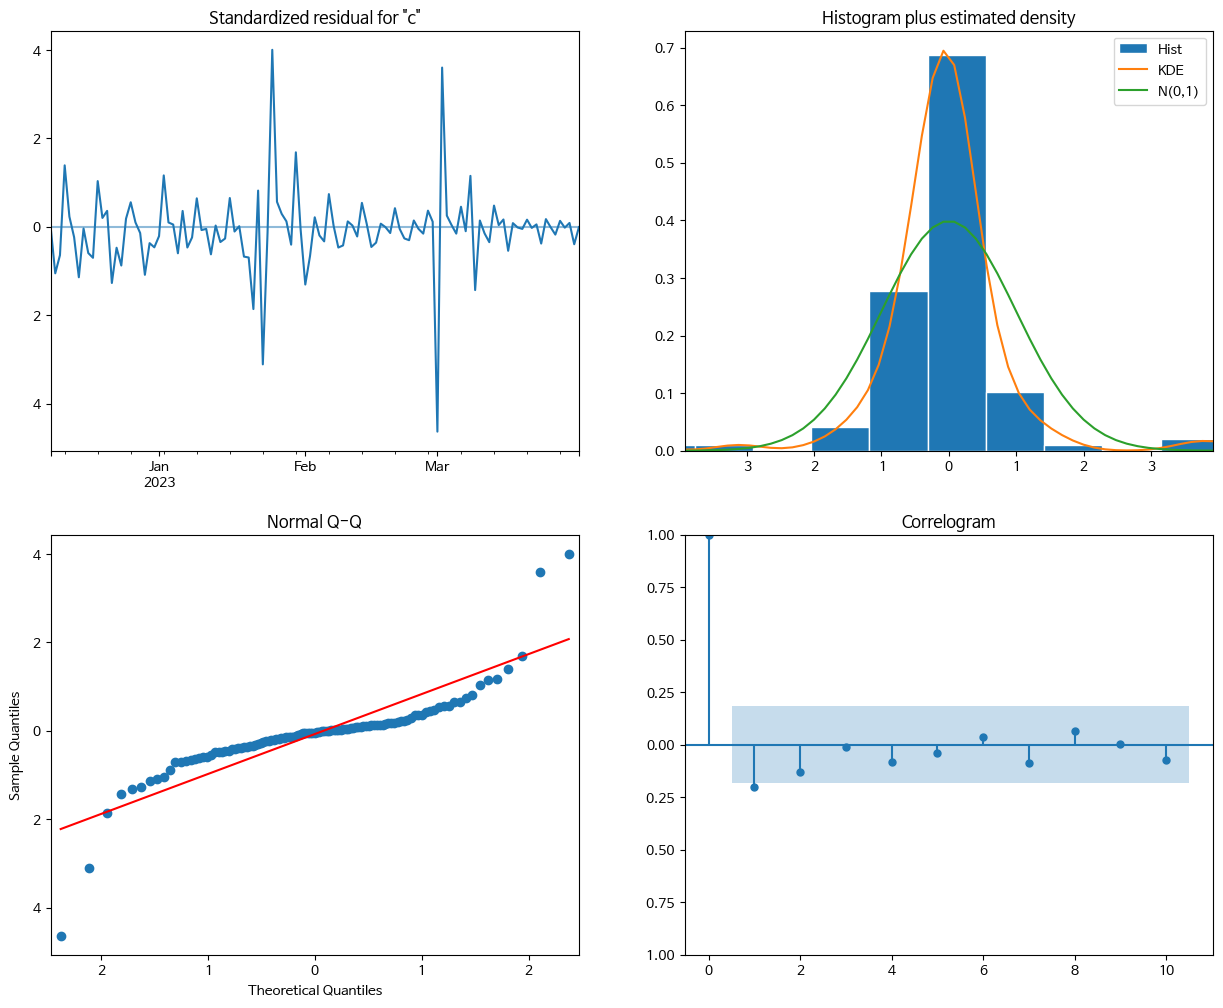

In [ ]:
SARIMA(sub_강남)

30
60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2633.101799401574
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1313.551
Date:                             Tue, 07 Nov 2023   AIC                           2633.102
Time:                                     05:15:25   BIC                           2641.284
Sample:                                 12-01-2022   HQIC                          2636.422
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2568      0.086  

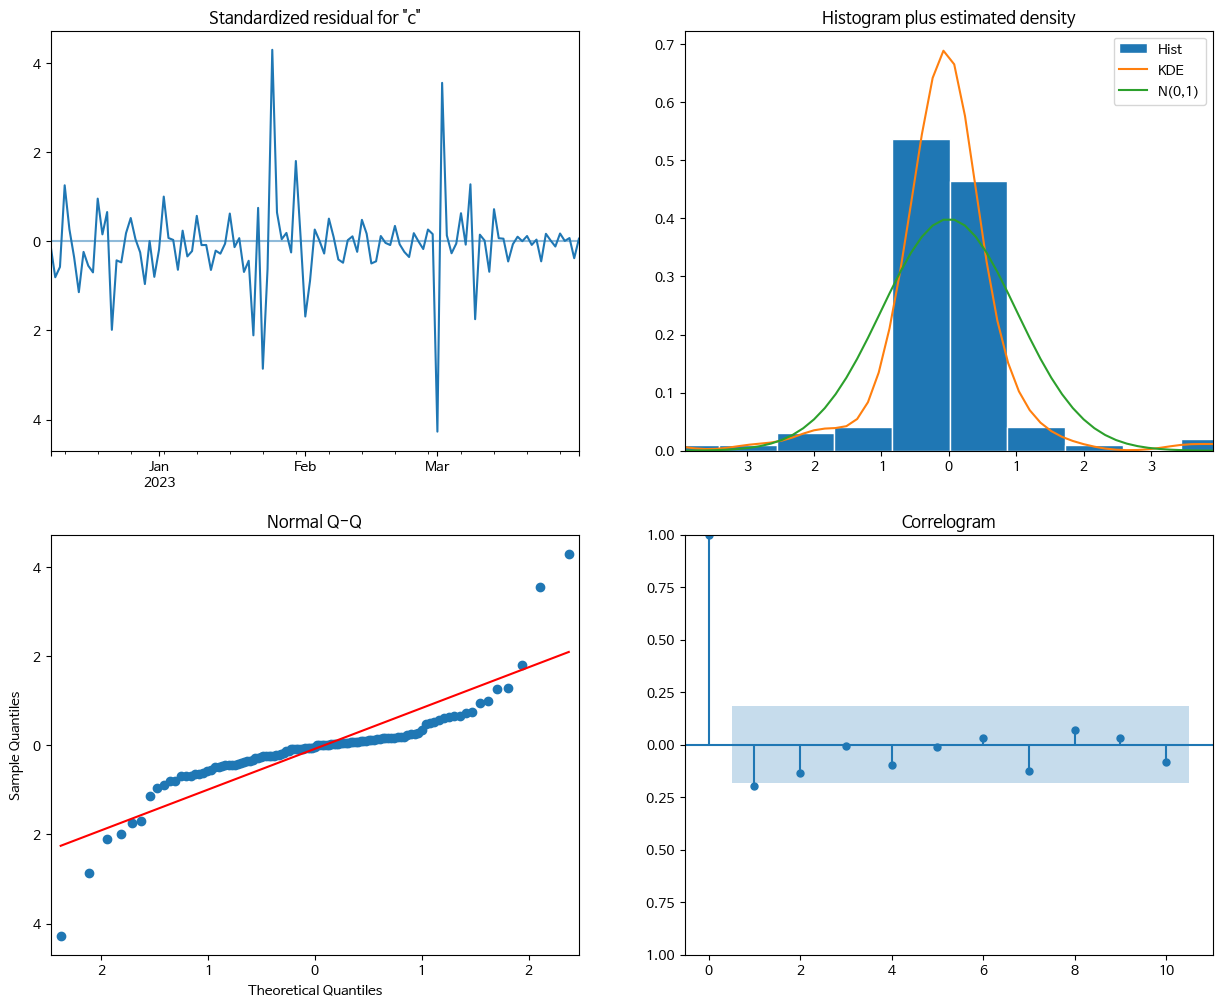

In [ ]:
SARIMA(sub_강서)

30
60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2531.166329819705
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1262.583
Date:                             Tue, 07 Nov 2023   AIC                           2531.166
Time:                                     05:16:41   BIC                           2539.348
Sample:                                 12-01-2022   HQIC                          2534.487
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2987      0.084  

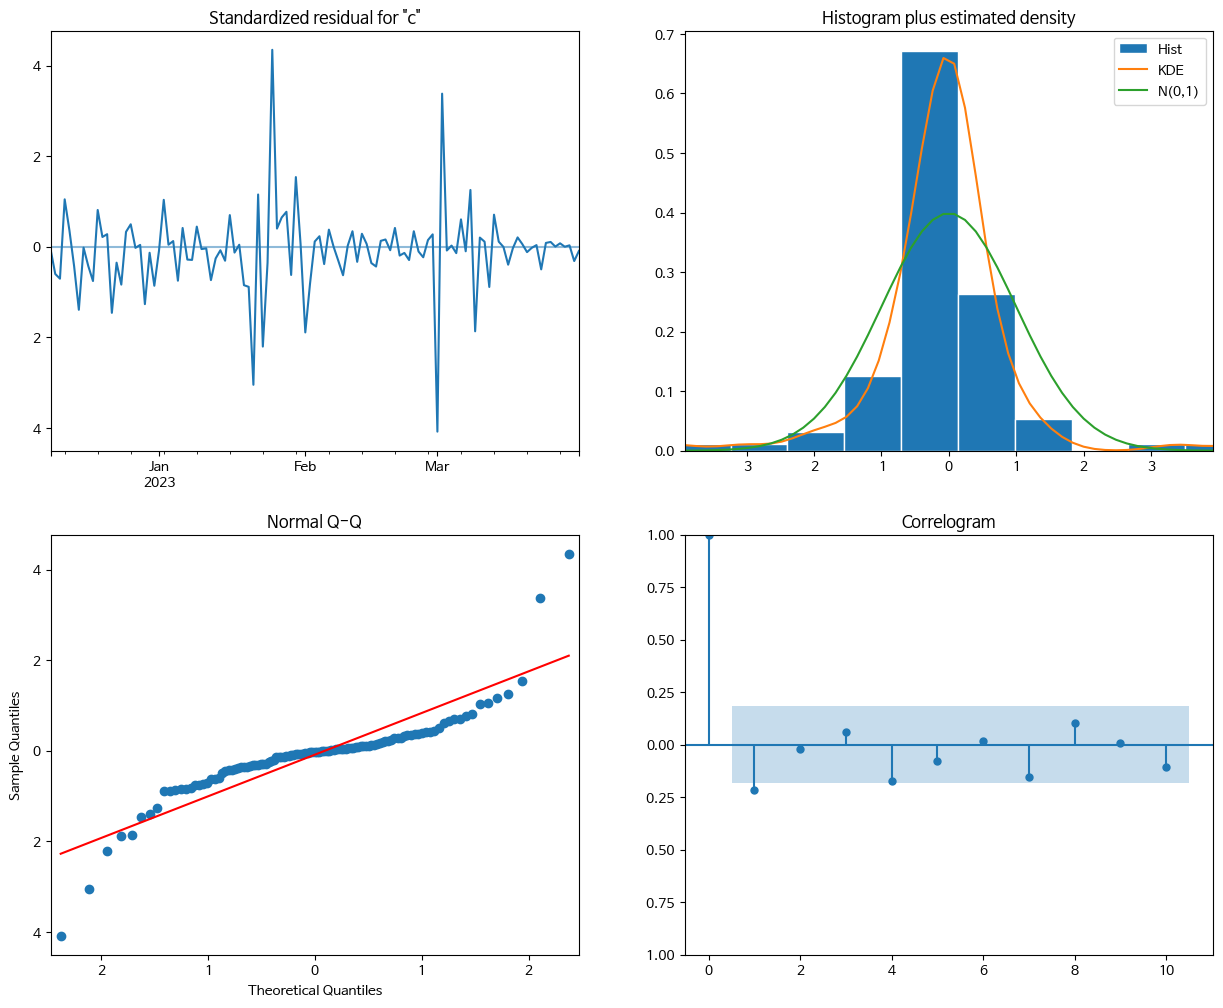

In [ ]:
SARIMA(sub_관악)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2584.035745176315
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1289.018
Date:                             Tue, 07 Nov 2023   AIC                           2584.036
Time:                                     05:17:49   BIC                           2592.218
Sample:                                 12-01-2022   HQIC                          2587.356
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2638      0.083     

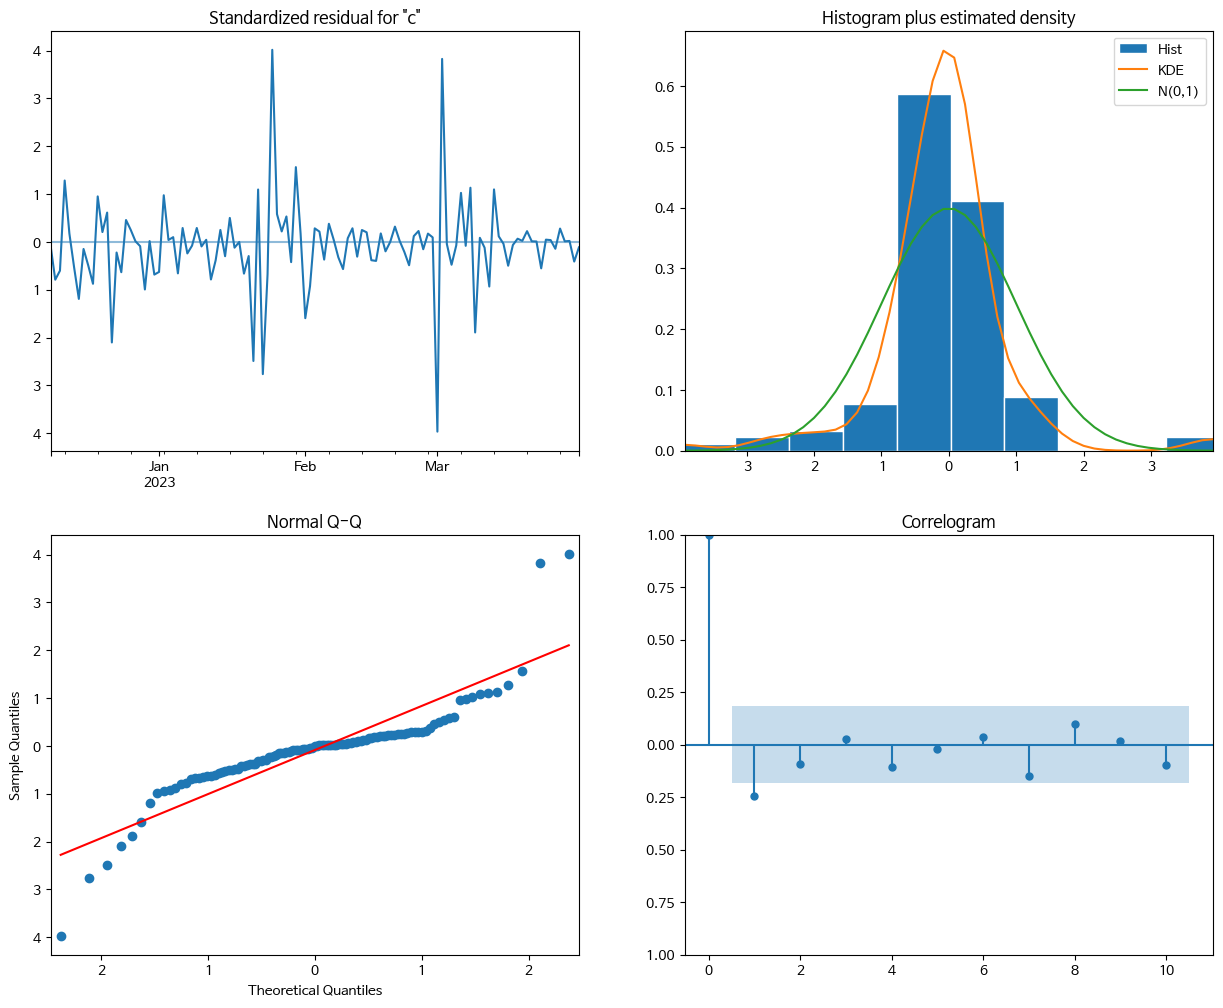

In [ ]:
SARIMA(sub_노원)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30
60
Best SARIMA(0, 1, 0)x(1, 1, 1, 7) model >> AIC: 2700.9904962356595
                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                  121
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -1347.495
Date:                             Tue, 07 Nov 2023   AIC                           2700.990
Time:                                     05:18:16   BIC                           2709.173
Sample:                                 12-01-2022   HQIC                          2704.311
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2499      0.089 

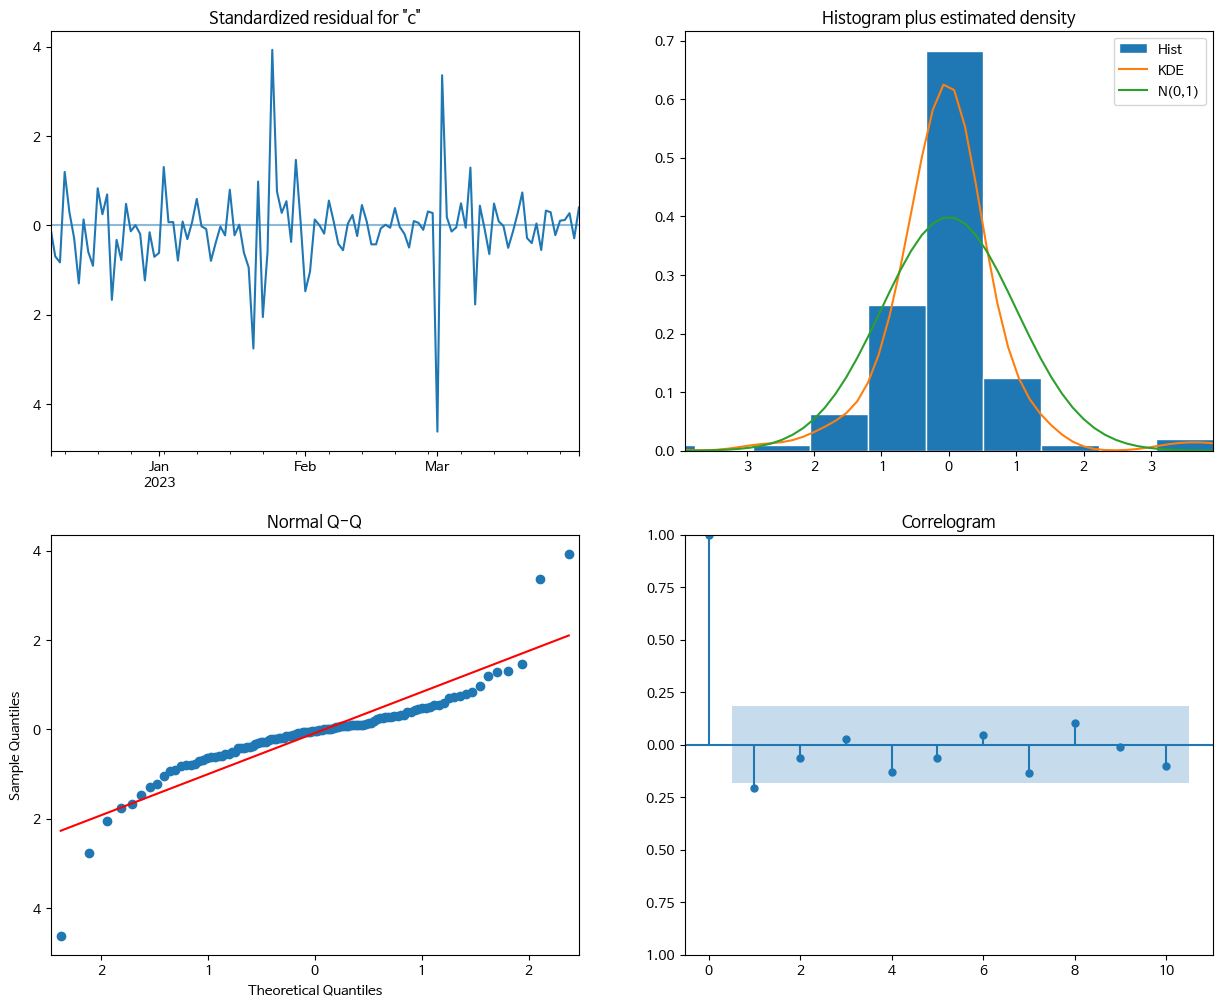

In [ ]:
SARIMA(sub_송파)

#표준화잔차

In [ ]:
def standardized_residuals(df):
    df['stdresid'] = (df['resid'] - np.mean(df['resid'])) / np.std(df['resid'])
    return df.head()

In [ ]:
standardized_residuals(sub_강남)
standardized_residuals(sub_강서)
standardized_residuals(sub_관악)
standardized_residuals(sub_노원)
standardized_residuals(sub_송파)

,area,count,resid,stdresid
2022-12-01,송파구,329212,329212.0,6.343313
2022-12-02,송파구,358075,28863.0,0.589291
2022-12-03,송파구,266833,-91242.0,-1.711655
2022-12-04,송파구,190538,-76295.0,-1.425304
2022-12-05,송파구,329587,139049.0,2.700211


In [ ]:
sub_강남.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강남_표준화잔차.csv')
sub_강서.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강서_표준화잔차.csv')
sub_관악.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_관악_표준화잔차.csv')
sub_노원.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_노원_표준화잔차.csv')
sub_송파.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_송파_표준화잔차.csv')

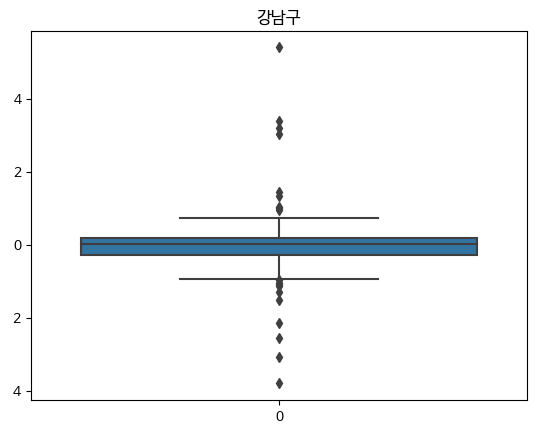

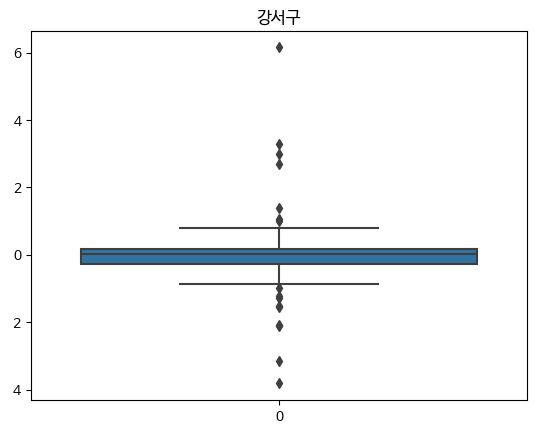

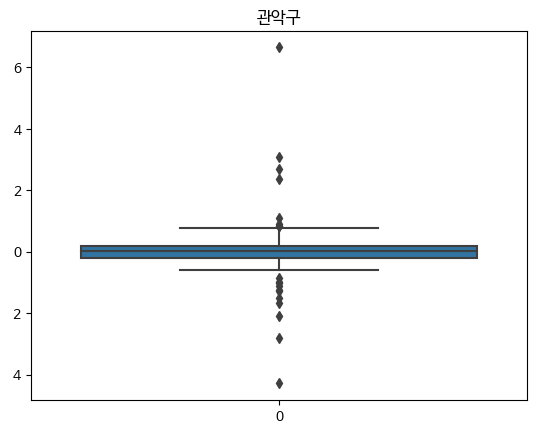

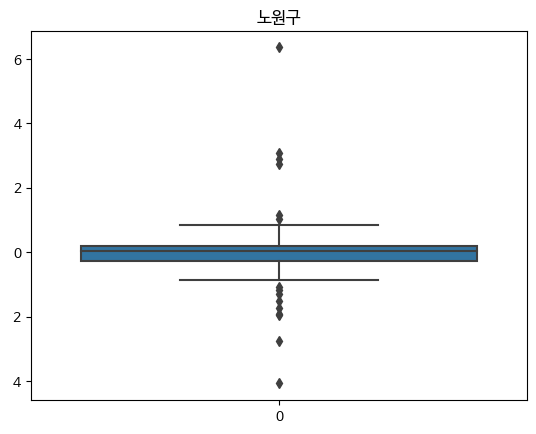

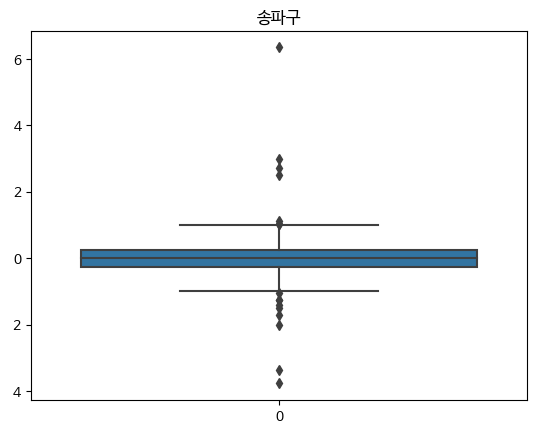

In [ ]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.title(df['area'][0])
    sns.boxplot(df['stdresid'])
    plt.show()

#이상치 탐지

In [ ]:
def find_outliers(df):
    outlier_df = pd.DataFrame()
    q3 = df['stdresid'].quantile(0.75)
    q1 = df['stdresid'].quantile(0.25)
    iqr = q3 - q1
    outlier_range = (df['stdresid'] < q1 - 1.5*iqr) | (df['stdresid'] > q3 + 1.5*iqr)
    outlier_df = df['stdresid'].loc[outlier_range]
    print(outlier_df)

In [ ]:
find_outliers(sub_강남)

2022-12-01    5.407332
2022-12-03   -2.152455
2022-12-04   -1.294590
2022-12-05    3.203216
2022-12-08   -3.071290
2022-12-12    1.328458
2022-12-15   -0.977323
2022-12-19    0.959378
2022-12-22   -1.066379
2023-01-02    1.035632
2023-01-21   -1.521968
2023-01-23   -2.572039
2023-01-25    3.398219
2023-01-30    1.447680
2023-02-01   -1.052520
2023-03-01   -3.806613
2023-03-02    3.026019
2023-03-08    0.994538
2023-03-09   -1.146862
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_강서)

2022-12-01    6.149312
2022-12-03   -2.073490
2022-12-04   -0.981860
2022-12-05    2.997882
2022-12-08   -3.815009
2022-12-12    1.074320
2022-12-22   -1.512864
2023-01-21   -1.555296
2023-01-23   -2.120548
2023-01-25    3.279017
2023-01-30    1.391760
2023-02-01   -1.231967
2023-03-01   -3.152412
2023-03-02    2.689817
2023-03-08    0.991126
2023-03-09   -1.266365
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_관악)

2022-12-01    6.647539
2022-12-03   -1.655982
2022-12-04   -1.115386
2022-12-05    2.685250
2022-12-08   -4.283219
2022-12-12    0.834337
2022-12-15   -0.988625
2022-12-22   -1.017665
2022-12-29   -0.867085
2023-01-21   -2.096163
2023-01-22    0.844825
2023-01-23   -1.505671
2023-01-25    3.080984
2023-01-30    1.110349
2023-02-01   -1.282443
2023-03-01   -2.790618
2023-03-02    2.376619
2023-03-08    0.904958
2023-03-09   -1.254145
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_노원)

2022-12-01    6.355759
2022-12-03   -1.944042
2022-12-04   -1.172137
2022-12-05    3.069391
2022-12-08   -4.078187
2022-12-12    1.040326
2022-12-22   -1.513559
2023-01-21   -1.738422
2023-01-23   -1.934343
2023-01-25    2.904012
2023-01-30    1.149809
2023-02-01   -1.095761
2023-03-01   -2.761512
2023-03-02    2.735963
2023-03-09   -1.295894
Name: stdresid, dtype: float64


In [ ]:
find_outliers(sub_송파)

2022-12-01    6.343313
2022-12-03   -1.711655
2022-12-04   -1.425304
2022-12-05    2.700211
2022-12-08   -3.773968
2022-12-12    1.020566
2022-12-22   -1.256596
2023-01-02    1.034884
2023-01-21   -2.024982
2023-01-23   -1.498352
2023-01-25    2.976062
2023-01-30    1.129236
2023-02-01   -1.062053
2023-03-01   -3.374732
2023-03-02    2.517367
2023-03-09   -1.268627
Name: stdresid, dtype: float64


✅ 2월 1일 이후가 별로 없다............!
